# Guía estructurada de la Tarea 1

Este notebook resume los hitos principales del enunciado para mantener un plan de trabajo ordenado. Avanza sección por sección y completa cada hito conforme desarrolles tu solución del proyecto.


In [1]:
# Configuración base para reproducibilidad
import os
import random
from pathlib import Path

import numpy as np

GLOBAL_SEED = 42
DATASET_ID = "010"

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)


## 1. E–T–P y framing

- Describe la Experiencia (E), la Tarea (T) y el Performance/criterio (P).
- Define el framing principal como clasificación binaria de `purchase` con salida probabilística.
- Justifica si usarás tasas agregadas y la decisión de negocio basada en umbrales.



## 2. Métricas y pérdida

- Usa log-loss (entropía cruzada) como pérdida principal.
- Reporta AUC y Brier score.
- Explica por qué MSE no es adecuado como objetivo principal y relaciónalo con máxima verosimilitud.



## 3. Diseño de validación y control de capacidad

- Define particiones train/valid/test (70/15/15) o k-fold para escoger hiperparámetros.
- Reentrena con los mejores hiperparámetros antes del test.
- Controla capacidad con regularización L2 (parámetro C) y grafica curvas train/valid vs. complejidad o learning curves.
- Explica el trade-off sesgo–varianza.



## 4. Preprocesamiento

- Explora el dataset para identificar duplicados, variables irrelevantes o leakage.
- Define codificación de variables categóricas, escalamiento y manejo de outliers o nulos según corresponda.



## 5. Modelado predictivo

- Entrena al menos dos modelos de clasificación (ej. regresión logística, árbol, random forest, XGBoost).
- Compara su desempeño inicial.



## 6. Evaluación

- Reporta métricas de clasificación: accuracy, precision, recall, F1-score y AUC-ROC.



## 7. Discusión de resultados

- Destaca variables relevantes para los modelos.
- Justifica columnas excluidas (especialmente leaks).
- Propón insights accionables para la empresa.



## 8. Política operativa y sensibilidad

- Formula una regla clara: contactar/ofrecer si la probabilidad estimada supera el umbral t.
- Analiza sensibilidad (ej. utilidad esperada por umbral) y discute implicancias.



## 9. Riesgos y mitigación

- Identifica al menos tres riesgos: leakage, sesgo de muestreo, shift temporal/segmento.
- Propón mitigaciones (auditoría de variables, validación por segmento o fuera de tiempo, calibration, A/B).



## 10. Resultados y conclusiones

- Resume hallazgos clave: saturación, desempeño en test, umbral recomendado.
- Indica cómo debe operar la empresa con el modelo final.



## Extras opcionales

- Mostrar efectos de usar `leak_after_offer` para evidenciar data leakage.
- Calcular métricas de negocio (ej. expected profit) usando `unit_margin_if_buy`.
- Comparar `discount` numérico vs. `discount_bucket`.



## Formato y reproducibilidad

- Declara semilla global y DATASET_ID en la primera celda.
- Fija semillas para NumPy/sklearn y repórtalas.
- Reporta versiones de librerías y hash SHA-256 del CSV.
- Trabaja sólo con el dataset entregado, sin regenerar datos.
- Entrega resultados específicos de tu dataset.



In [2]:
# Punto 1: E–T–P y framing del proyecto
import textwrap
from pathlib import Path

import pandas as pd

# Carga del dataset individual y descarte explícito de columnas con leakage.
dataset_path = Path(f"T1_{DATASET_ID}_individual.csv")
raw_df = pd.read_csv(dataset_path)

print(f"Registros: {raw_df.shape[0]}, columnas: {raw_df.shape[1]}")
leak_columns = [col for col in raw_df.columns if col.startswith("leak")]
if leak_columns:
    print("Columnas marcadas como leakage y excluidas del modelado:", leak_columns)

# `df` será la versión libre de leakage utilizada para cualquier modelado posterior.
df = raw_df.drop(columns=leak_columns)

FEATURE_COLUMNS = [
    "segment",
    "discount",
    "age",
    "tenure_months",
    "income_index",
    "web_visits_30d",
    "unit_margin_if_buy",
    "discount_bucket",
]
TARGET_COLUMN = "purchase"
CATEGORICAL_FEATURES = ["segment", "discount_bucket"]
NUMERICAL_FEATURES = [
    "discount",
    "age",
    "tenure_months",
    "income_index",
    "web_visits_30d",
    "unit_margin_if_buy",
]

etp_framing = {
    "experiencia": (
        "Campaña outbound para clientes del segmento de retail financiero en la que cada fila del dataset "
        "representa un contacto individual previo al envío de una oferta de descuento."
    ),
    "tarea": (
        "Predecir si el cliente concretará la compra del producto ofrecido (variable purchase) a partir de "
        "la información disponible antes de realizar la oferta."
    ),
    "performance": (
        "Evaluar la calidad de las predicciones probabilísticas minimizando log-loss y maximizando métricas "
        "discriminativas como AUC, para tomar decisiones comerciales basadas en umbrales."
    ),
    "framing": (
        "Se modelará como un problema de clasificación binaria con salida probabilística sobre purchase. "
        "Esto permite fijar umbrales de contacto para priorizar a los clientes con mayor propensión."
    ),
    "politica_umbral": (
        "La operación aplicará un umbral sobre la probabilidad estimada: se contacta al cliente solo si la "
        "probabilidad supera t, lo que permite gestionar la capacidad y maximizar retorno esperado."
    ),
}

for clave, descripcion in etp_framing.items():
    print(clave.upper())
    print(textwrap.fill(descripcion, width=100))
    print()


Registros: 6000, columnas: 11
Columnas marcadas como leakage y excluidas del modelado: ['leak_after_offer']
EXPERIENCIA
Campaña outbound para clientes del segmento de retail financiero en la que cada fila del dataset
representa un contacto individual previo al envío de una oferta de descuento.

TAREA
Predecir si el cliente concretará la compra del producto ofrecido (variable purchase) a partir de la
información disponible antes de realizar la oferta.

PERFORMANCE
Evaluar la calidad de las predicciones probabilísticas minimizando log-loss y maximizando métricas
discriminativas como AUC, para tomar decisiones comerciales basadas en umbrales.

FRAMING
Se modelará como un problema de clasificación binaria con salida probabilística sobre purchase. Esto
permite fijar umbrales de contacto para priorizar a los clientes con mayor propensión.

POLITICA_UMBRAL
La operación aplicará un umbral sobre la probabilidad estimada: se contacta al cliente solo si la
probabilidad supera t, lo que permite ge

In [3]:
# Punto 2: Métricas, pérdida y justificación del criterio probabilístico
from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Particiones estratificadas 70/15/15.
X = df[FEATURE_COLUMNS]
y = df[TARGET_COLUMN]

X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    stratify=y,
    random_state=GLOBAL_SEED,
)

validation_size = 0.15 / 0.85  # asegura ~15 % del total
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp,
    y_temp,
    test_size=validation_size,
    stratify=y_temp,
    random_state=GLOBAL_SEED,
)

split_counts = {
    "train": len(X_train),
    "valid": len(X_valid),
    "test": len(X_test),
}
print("Distribución de filas por partición (aprox. 70/15/15):", split_counts)


def build_pipeline(C: float = 1.0) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ("categorical", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_FEATURES),
            ("numeric", Pipeline([("scaler", StandardScaler())]), NUMERICAL_FEATURES),
        ]
    )
    classifier = LogisticRegression(
        penalty="l2",
        C=C,
        random_state=GLOBAL_SEED,
        max_iter=2000,
        solver="lbfgs",
    )
    return Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])


baseline_model = build_pipeline(C=1.0)
baseline_model.fit(X_train, y_train)

train_proba = baseline_model.predict_proba(X_train)[:, 1]
valid_proba = baseline_model.predict_proba(X_valid)[:, 1]

metricas = pd.DataFrame(
    {
        "log_loss": [
            log_loss(y_train, train_proba),
            log_loss(y_valid, valid_proba),
        ],
        "auc": [
            roc_auc_score(y_train, train_proba),
            roc_auc_score(y_valid, valid_proba),
        ],
        "brier_score": [
            brier_score_loss(y_train, train_proba),
            brier_score_loss(y_valid, valid_proba),
        ],
    },
    index=["train", "valid"],
).round(4)

print()
print("Métricas base (Regresión Logística con L2, C=1.0):")
display(metricas)

mse_explicacion = (
    "La pérdida log-loss coincide con la maximización de la verosimilitud de un modelo Bernoulli y penaliza con mayor "
    "fuerza las probabilidades mal calibradas. Usar MSE como objetivo para clasificación binaria rompe esta relación "
    "probabilística, produce gradientes pobres cerca de los extremos y no prioriza la calibración, por lo que no es "
    "adecuado como criterio principal."
)

print()
print("Justificación sobre el rechazo de MSE:")
print(textwrap.fill(mse_explicacion, width=100))


Distribución de filas por partición (aprox. 70/15/15): {'train': 4199, 'valid': 901, 'test': 900}

Métricas base (Regresión Logística con L2, C=1.0):


,log_loss,auc,brier_score
train,0.3986,0.8664,0.1285
valid,0.4128,0.8606,0.1322



Justificación sobre el rechazo de MSE:
La pérdida log-loss coincide con la maximización de la verosimilitud de un modelo Bernoulli y
penaliza con mayor fuerza las probabilidades mal calibradas. Usar MSE como objetivo para
clasificación binaria rompe esta relación probabilística, produce gradientes pobres cerca de los
extremos y no prioriza la calibración, por lo que no es adecuado como criterio principal.


Resultados de control de capacidad (menor log-loss es mejor):


,C,train_log_loss,valid_log_loss,valid_auc,valid_brier
0,0.001,0.4484,0.4501,0.8630,0.1440
1,0.010,0.4036,0.4113,0.8618,0.1315
2,0.100,0.3993,0.4118,0.8608,0.1319
3,1.000,0.3986,0.4128,0.8606,0.1322
4,10.000,0.3984,0.4129,0.8605,0.1323
5,100.000,0.3983,0.4129,0.8605,0.1323
6,1000.000,0.3983,0.4130,0.8605,0.1324


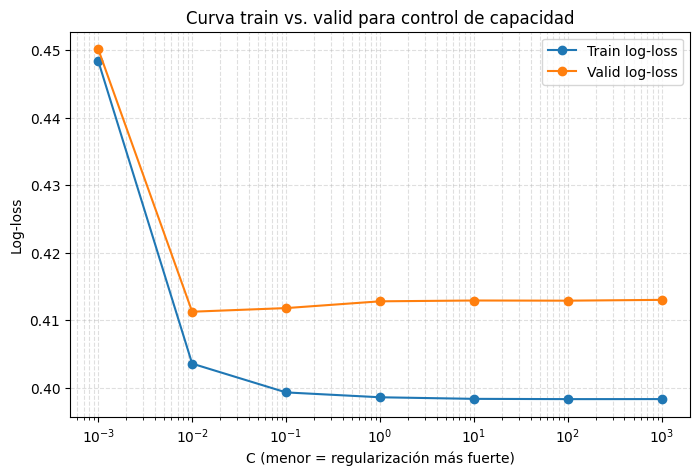

Mejor C (mínimo log-loss en validación): 0.0100
La curva evidencia el clásico compromiso sesgo-varianza: con C muy pequeños (regularización fuerte)
el modelo subajusta y la pérdida en train/valid es alta; con C muy grandes reduce el sesgo pero
incrementa la varianza, empeorando la log-loss en validación. Seleccionamos el C que equilibra ambas
curvas para generalizar mejor.


In [4]:
# Punto 3: Diseño de validación y control de capacidad (Regresión Logística L2)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score

regularization_grid = np.logspace(-3, 3, num=7)
capacity_results = []

for C in regularization_grid:
    candidate = build_pipeline(C=C)
    candidate.fit(X_train, y_train)
    train_proba = candidate.predict_proba(X_train)[:, 1]
    valid_proba = candidate.predict_proba(X_valid)[:, 1]
    capacity_results.append(
        {
            "C": C,
            "train_log_loss": log_loss(y_train, train_proba),
            "valid_log_loss": log_loss(y_valid, valid_proba),
            "valid_auc": roc_auc_score(y_valid, valid_proba),
            "valid_brier": brier_score_loss(y_valid, valid_proba),
        }
    )

capacity_df = pd.DataFrame(capacity_results)
print("Resultados de control de capacidad (menor log-loss es mejor):")
display(capacity_df.round({"C": 4, "train_log_loss": 4, "valid_log_loss": 4, "valid_auc": 4, "valid_brier": 4}))

plt.figure(figsize=(8, 5))
plt.semilogx(capacity_df["C"], capacity_df["train_log_loss"], marker="o", label="Train log-loss")
plt.semilogx(capacity_df["C"], capacity_df["valid_log_loss"], marker="o", label="Valid log-loss")
plt.xlabel("C (menor = regularización más fuerte)")
plt.ylabel("Log-loss")
plt.title("Curva train vs. valid para control de capacidad")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.show()

BEST_LOGREG_C = float(capacity_df.loc[capacity_df["valid_log_loss"].idxmin(), "C"])
print(f"Mejor C (mínimo log-loss en validación): {BEST_LOGREG_C:.4f}")
print(
    textwrap.fill(
        "La curva evidencia el clásico compromiso sesgo-varianza: con C muy pequeños (regularización fuerte) el modelo "
        "subajusta y la pérdida en train/valid es alta; con C muy grandes reduce el sesgo pero incrementa la varianza, "
        "empeorando la log-loss en validación. Seleccionamos el C que equilibra ambas curvas para generalizar mejor.",
        width=100,
    )
)
